# Exploring the distribution of ambiguous (N/A) values in the EBR arrays (Aggregated EBR (mean across 36 isolates) & individual EBR arrays)

### Goal: To summarize the characteristics of regions that are "ambiguous"/ N/A individual EBR arrays 

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

#### Pandas Viewing Settings

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Parse Assembly and Sequence analysis results Sample Info

In [3]:
Repo_DataDir = "../../Data"

PMP_SM_ResultsSummary_Dir_210108 = Repo_DataDir + "/210108_PMP_SM_50CI_V7_ResultsSummary"

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv"       

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary = pd.read_csv(PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_AnalysisSet_AssemblySummary = PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary


SampleIDs_36CI_SOI = list( PMP_36CI_AnalysisSet_AssemblySummary["SampleID"].values )


print(','.join(SampleIDs_36CI_SOI) )

# Make sample to metadata mapping dicts

ID_To_IlluminaAvrgCov_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'IlluminaWGSToH37rv_AvrgCov']].values)                     
ID_To_Lineage_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'PrimaryLineage_PB']].values)
ID_To_Dataset_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'Dataset_Tag']].values)

M0011368_9,M0014888_3,M0016395_7,M0010874_7,01_R1430,02_R0894,02_R1708,02_R1896,M0016737_0,M0017522_5,01_R1134,M0003941_3,02_R1179,N1176,N0072,N0153,N0145,N0155,N0004,N1274,N0054,N1272,N0091,N1202,N1177,RW-TB008,DNA028,DNA075,DNA091,DNA044,DNA020,AZE_02_042,DNA019_Rose,DNA120,DNA188,DNA086


In [4]:
len(SampleIDs_36CI_SOI)

36

In [5]:
SampleIDs_36CI_SOI

['M0011368_9',
 'M0014888_3',
 'M0016395_7',
 'M0010874_7',
 '01_R1430',
 '02_R0894',
 '02_R1708',
 '02_R1896',
 'M0016737_0',
 'M0017522_5',
 '01_R1134',
 'M0003941_3',
 '02_R1179',
 'N1176',
 'N0072',
 'N0153',
 'N0145',
 'N0155',
 'N0004',
 'N1274',
 'N0054',
 'N1272',
 'N0091',
 'N1202',
 'N1177',
 'RW-TB008',
 'DNA028',
 'DNA075',
 'DNA091',
 'DNA044',
 'DNA020',
 'AZE_02_042',
 'DNA019_Rose',
 'DNA120',
 'DNA188',
 'DNA086']

# 0) Read in pickles of processed data

## Read back in pickle of "dictOf_EBR_31CI_DFs"

In [6]:
PB_Vs_Illumina_DataAnalysis_Dir = "../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI"

# Define directory for EBR analysis data
PBvIll_EBR_Dir = PB_Vs_Illumina_DataAnalysis_Dir + "/210112_EBR_H37rv_36CI_MM2vsPilon_V7"         

PBvsIll_EBR_IndivSample_NPZs = f"{PBvIll_EBR_Dir}/210112_EBR_H37rv_IndividualSampleRecall_NPZs"


# Parse in aggregated EBR-36CI array
EBR_36CI_WGS40X_NPZ_PATH = f"{PBvIll_EBR_Dir}/210112_EBR_V7_36CI.npz"

EBR_36CI_Array_A4 = np.load(EBR_36CI_WGS40X_NPZ_PATH)["arr_0"]



# Parse in individual EBR arrays for each isolate and store in dictionary
dictOf_EBR_IndivIsolate_NPYs= {}

for SampleID in tqdm(SampleIDs_36CI_SOI):
    
    i_EBR_Agreement_NPZ_PATH = f"{PBvsIll_EBR_IndivSample_NPZs}/EBR.V7.IndivIsolate.{SampleID}.npz"

    i_EBR_NP = np.load(i_EBR_Agreement_NPZ_PATH)["arr_0"]

    dictOf_EBR_IndivIsolate_NPYs[SampleID] = i_EBR_NP


100%|██████████| 36/36 [00:03<00:00, 11.48it/s]


In [7]:
dictOf_EBR_IndivIsolate_NPYs.keys()

dict_keys(['M0011368_9', 'M0014888_3', 'M0016395_7', 'M0010874_7', '01_R1430', '02_R0894', '02_R1708', '02_R1896', 'M0016737_0', 'M0017522_5', '01_R1134', 'M0003941_3', '02_R1179', 'N1176', 'N0072', 'N0153', 'N0145', 'N0155', 'N0004', 'N1274', 'N0054', 'N1272', 'N0091', 'N1202', 'N1177', 'RW-TB008', 'DNA028', 'DNA075', 'DNA091', 'DNA044', 'DNA020', 'AZE_02_042', 'DNA019_Rose', 'DNA120', 'DNA188', 'DNA086'])

In [8]:
np.nanmean(EBR_36CI_Array_A4)

0.9886257598437438

### Approach #2) Add together all sample EBR agreement vectors, remove NAN values from vector, and normalize by # of samples with NON-NAN values.

This approach results in positions with only 25 NON-NAN values, being normalized by 25 samples instead of the 28 total.


In [9]:
#EBR_28CI_WGS40X_Array_A2 = np.zeros( (4411532,) )

Num_NonNAN_Values_Array_A2 = np.zeros( (4411532,) )

Num_NAN_Values_H37Rv_Array_A2 = np.zeros( (4411532,) )

for SampleID in tqdm( SampleIDs_36CI_SOI ) :
    
    i_EBR_Array = dictOf_EBR_IndivIsolate_NPYs[SampleID]
    
    #print( np.nanmean(i_EBR_Array) )
    
    Num_NAN_Values_H37Rv_Array_A2 += (np.isnan(i_EBR_Array)).astype(int)
    
    Num_NonNAN_Values_Array_A2 += (~np.isnan(i_EBR_Array)).astype(int)
    


100%|██████████| 36/36 [00:04<00:00,  5.59it/s]


In [10]:
(Num_NAN_Values_H37Rv_Array_A2.sum() + Num_NonNAN_Values_Array_A2.sum() ) / len(SampleIDs_36CI_SOI)   

4411532.0

In [11]:
Num_NAN_Values_H37Rv_Array_A2.sum()

654083.0

In [12]:
Num_NonNAN_Values_Array_A2.sum()

158161069.0

In [13]:
np.isnan(i_EBR_Array).sum()

13234

In [14]:
(~np.isnan(i_EBR_Array)).astype(int)

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
Num_NonNAN_Values_Array_A2.shape

(4411532,)

In [16]:
(Num_NonNAN_Values_Array_A2 == 40).sum() + (Num_NonNAN_Values_Array_A2 < 40).sum()

4411532

### How many positions have 0 NA values?

In [17]:
(Num_NonNAN_Values_Array_A2 == 40).sum()  

0

### How many positions have 1 or more NA values?

In [18]:
(Num_NonNAN_Values_Array_A2 < 40).sum()  

4411532

In [19]:
136881 / 4411532

0.03102799662339523

In [20]:
0.25 * 40

10.0

In [21]:
Num_NonNAN_Values_Array_A2.sum()

158161069.0

In [22]:
(Num_NonNAN_Values_Array_A2 <= 10).sum()

3512

In [23]:
NumNANs_H37Rv_Pos_NPY = (36 - Num_NonNAN_Values_Array_A2)

In [24]:
(NumNANs_H37Rv_Pos_NPY == Num_NAN_Values_H37Rv_Array_A2).sum()

4411532

In [25]:
Num_NAN_Values_H37Rv_Array_A2.mean()

0.14826663390404965

In [26]:
NumNANs_H37Rv_Pos_NPY.mean()

0.14826663390404965

In [27]:
Num_NAN_Values_H37Rv_Array_A2 = Num_NAN_Values_H37Rv_Array_A2[Num_NAN_Values_H37Rv_Array_A2 != 0]      

In [28]:
NumNAN_nonZero_NPY = Num_NAN_Values_H37Rv_Array_A2

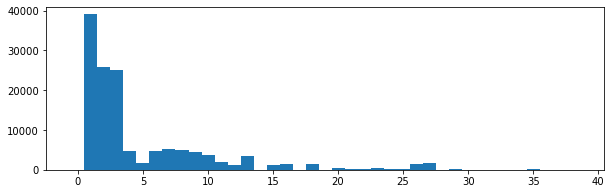

In [29]:
binwidth = 1
Min = -1
Max = 38
bins_I = np.arange(Min + (binwidth/2), Max + (binwidth), binwidth)

fig, axs = plt.subplots(1, 1, figsize=(10, 3), sharex=False)

axs.hist(NumNAN_nonZero_NPY, bins = bins_I, density=False)

#axs.set_xlim(0,1.05)
#axs.set_title("All Base Pair Positions of H37rv", fontsize=16)
#axs.set_ylabel("# of bp", fontsize=14)
#axs.set_xlabel("Empirical Base Pair Recall (EBR)", fontsize=14)


#Output_PNG_PATH = "./H37rv_GenomeMetrics_Plots/EBPR31_AcrossAllPositionsOf_H37rv.png"
#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=75)
plt.show()

In [30]:
(Num_NonNAN_Values_Array_A2 <= 10).sum()

3512

In [31]:
NumNANs_H37Rv_Pos_NPY.shape

(4411532,)

In [32]:
(NumNANs_H37Rv_Pos_NPY > 6).sum()

34228

In [33]:
(NumNANs_H37Rv_Pos_NPY > 7).sum()

29100

In [34]:
(NumNANs_H37Rv_Pos_NPY >= 10).sum()

19607

In [35]:
(NumNANs_H37Rv_Pos_NPY >= 10).sum()

19607

In [36]:
(NumNANs_H37Rv_Pos_NPY == 28).sum()

18

In [37]:
(NumNANs_H37Rv_Pos_NPY == 36).sum()

62

In [38]:
(NumNANs_H37Rv_Pos_NPY >= 1).sum() / (NumNANs_H37Rv_Pos_NPY >= 0).sum() 

0.030641736249448038

In [39]:
## 3.1% of the H37Rv genome has at least 1 NAN 

In [40]:
(NumNANs_H37Rv_Pos_NPY > 7).sum() / (NumNANs_H37Rv_Pos_NPY >= 1).sum() 

0.21527330832907965

In [41]:
(NumNANs_H37Rv_Pos_NPY > 7).sum() / (NumNANs_H37Rv_Pos_NPY >= 1).sum() 

0.21527330832907965

In [42]:
(NumNANs_H37Rv_Pos_NPY > 9).sum() / (NumNANs_H37Rv_Pos_NPY >= 1).sum() 

0.14504686448138368

In [43]:
17969 / 4411532

0.004073188180432557

In [44]:
(NumNANs_H37Rv_Pos_NPY > 4).sum() / 4411532

0.00921607278378577

In [45]:
(NumNANs_H37Rv_Pos_NPY > 6).sum() / 4411532

0.007758755915178672

In [46]:
(NumNANs_H37Rv_Pos_NPY > 7).sum() / 4411532

0.006596347935365764

In [47]:
(NumNANs_H37Rv_Pos_NPY > 9).sum() / 4411532

0.004444487765247991

In [48]:
(NumNANs_H37Rv_Pos_NPY > 7).sum() 

29100

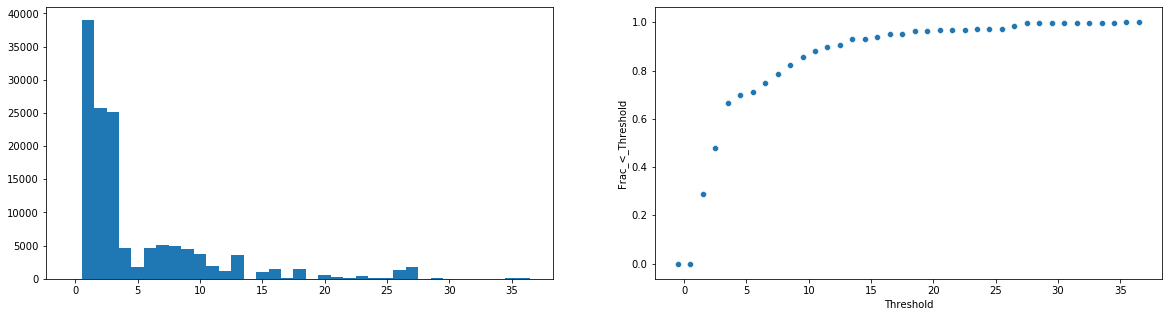

,Threshold,Frac_<_Threshold
33,32.5,0.998180
34,33.5,0.998180
35,34.5,0.998239
36,35.5,0.999541
37,36.5,1.000000


In [50]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=False)

input_Array = NumNAN_nonZero_NPY

binwidth = 1
Min = -1
Max = 36
bins_I = np.arange(Min + (binwidth/2), Max + (binwidth), binwidth)


listOfTuples = []

for thresh in bins_I:
    
    PropAboveThresh = (input_Array < thresh).sum() / len(input_Array)
    
    CDF_Tuple = (thresh, PropAboveThresh)
    
    listOfTuples.append(CDF_Tuple)
    
CDF_DF = pd.DataFrame( listOfTuples )
CDF_DF.columns = ["Threshold", "Frac_<_Threshold"]


#binwidth = 0.05
#Min = 0
#Max = 1.05
bins_I = np.arange(Min + (binwidth/2), Max + (binwidth), binwidth)

axs[0].hist(input_Array, bins = bins_I, density=False)

#axs[0].set_xlim(0,1.05)

sns.scatterplot(x="Threshold", y = "Frac_<_Threshold", data=CDF_DF, ax = axs[1])
#axs[1].set_xlim(0,1.05)
plt.show()

CDF_DF.tail(5)